<a href="https://colab.research.google.com/github/bhanuteja2001/SegPC-2021/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install segmentation-models

In [ ]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

In [ ]:
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

In [ ]:
%matplotlib inline

In [8]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [6]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [56]:
import segmentation_models as sm
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
len(os.listdir('/content/drive/MyDrive/SegPC-2021/x'))

298

(192, 256, 3)


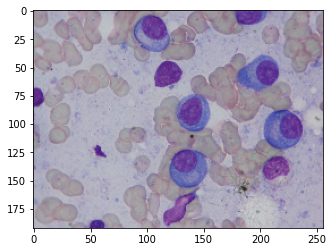

In [10]:
img_path = "/content/drive/MyDrive/Segpc2021/train/x/106.bmp"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (256, 192))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)

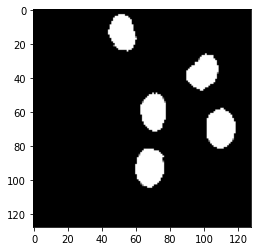

In [12]:
mask_path = "/content/drive/MyDrive/Segpc2021/train/y/106.bmp"
mask = cv2.imread(mask_path, 0)
mask = cv2.resize(mask, (128, 128))
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
plt.imshow(mask)

In [13]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 192 #Resize images (height  = X, width = Y)
SIZE_Y = 256

train_images = []

for imgs in tqdm(os.listdir("/content/drive/MyDrive/Segpc2021/train/x")):
  img_path = "/content/drive/MyDrive/Segpc2021/train/x/" + imgs
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)
train_images = np.array(train_images)

train_masks = []

for imgs in tqdm(os.listdir("/content/drive/MyDrive/Segpc2021/train/y")):
  mask_path = "/content/drive/MyDrive/Segpc2021/train/y/" + imgs
  mask = cv2.imread(mask_path, 0)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
  train_masks.append(mask)

train_masks = np.array(train_masks)

100%|██████████| 298/298 [02:26<00:00,  2.03it/s]


In [ ]:
train_images.shape

(298, 240, 320, 3)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

CLASSES = ['Cytoplasm', 'Nucleus']
LR = 0.0001

In [57]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 0s 0us/step


In [58]:
import keras

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (cytoplasm: 1.; nucleus: 2.; background: 0;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoints_every_epoch = '/content/drive/MyDrive/SegPC-2021/checkpoints/checkpoint_{epoch:03d}'
    checkpoint1 = ModelCheckpoint(filepath=checkpoints_every_epoch,
                                  monitor = 'iou_score',
                                  frequency='epoch',
                                  save_best_only=True,
                                  save_weight_only=False,
                                  verbose=1,
                                  mode ='auto')
    checkpoint2 = EarlyStopping(monitor='iou_score', patience=5, verbose=1, restore_best_weights=True)
    
    return checkpoint1, checkpoint2

checkpoint_every_epoch = list(get_checkpoint_every_epoch())

In [59]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Checkpoint/best_model1.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        #channel_shift_range=150.0,
        vertical_flip=True,
        horizontal_flip=True,
        #brightness_range=[0.4,1.5]
        preprocessing_function=preprocess_input
        )
        
val_datagen = ImageDataGenerator(rescale=1./255,
                                 vertical_flip=True,
                                 horizontal_flip=True,
                                 #brightness_range=[0.4,1.5]
                                 preprocessing_function=preprocess_input
                                 )

BS = 32
EPOCHS = 20

H = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size = BS, shuffle=True),
    epochs=EPOCHS,
    #verbose=1,
    validation_data=val_datagen.flow(x_val, y_val, batch_size = 1, shuffle = False),
    callbacks=callbacks
    )

accuracy = model.evaluate(x_val, y_val)

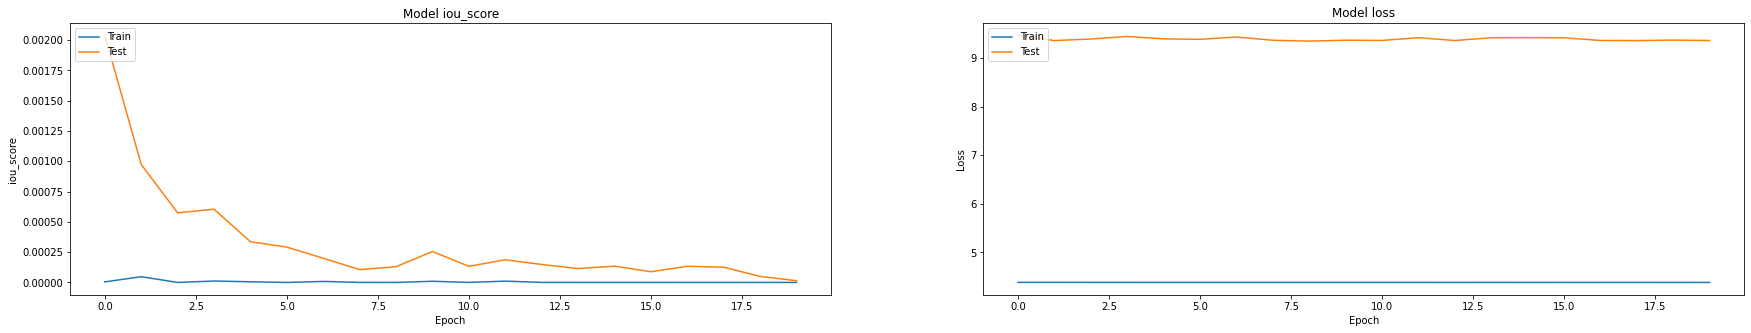

In [31]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(H.history['iou_score'])
plt.plot(H.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=1000,
   verbose=1,
   validation_data=(x_val, y_val),
)

Train on 238 samples, validate on 60 samples
Epoch 1/1000
238/238 [==============================] - 18s 74ms/step - loss: 0.1264 - iou_score: 0.8177 - val_loss: -0.7372 - val_iou_score: 6.8869
Epoch 2/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.2577 - iou_score: 1.7584 - val_loss: -0.3280 - val_iou_score: 1.9894
Epoch 3/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.5004 - iou_score: 3.0493 - val_loss: 0.2467 - val_iou_score: 0.6068
Epoch 4/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.6322 - iou_score: 4.4481 - val_loss: -0.7258 - val_iou_score: 6.2867
Epoch 5/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.7216 - iou_score: 6.2704 - val_loss: -0.9153 - val_iou_score: 22.6457
Epoch 6/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.7782 - iou_score: 8.1435 - val_loss: -0.9017 - val_iou_score: 19.3467
Epoch 7/1000
238/238 [==============================] - 2s 8ms/st

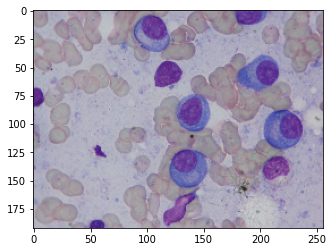

In [47]:
test_img = cv2.imread("/content/drive/MyDrive/Segpc2021/train/x/106.bmp", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X),3)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

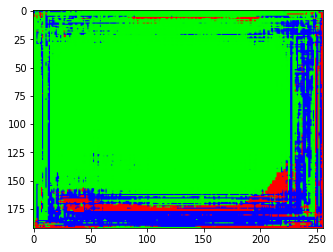

In [50]:
prediction_image = prediction.reshape(192,256,3)
plt.imshow(prediction_image)